In [22]:
import sys
import importlib
import yaml
import psycopg2
import networkx
from pyvis.network import Network
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from psycopg2.extras import execute_values
import networkx
from pyvis.network import Network


sys.path.insert(0, ".")

import sql_functions as sf
importlib.reload(sf)

<module 'sql_functions' from 'C:\\Users\\KeikoGolden\\ComputationalLiguistics\\Annotaion\\bn_nb_s\\PythonTocheckModel\\.\\sql_functions.py'>

In [23]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 20]

In [24]:
import pandas as pd
import torch
import numpy as np
from typing import *

In [27]:
import yaml
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from psycopg2.extras import execute_values


with open("./config.yml") as f:
    config = yaml.safe_load(f)

In [29]:
conn = psycopg2.connect(
        database=config['db']['name'], 
        user=config['db']['user'], 
        host=config['db']['host'], 
        password=config['db']['password']
    )

cur = conn.cursor()

# Read in data

In [ ]:
edge_df = sf.get_all_edges(cur)
edge_df

In [ ]:
main_df = pd.read_sql("""
    select * from skills 
    where removed is not False
""", conn)

In [14]:
import boto3
import json
from typing import *

region = "ca-central-1"
vectorizer_name = "vectorizer-cpu-2"
sagemaker_runtime = boto3.client("sagemaker-runtime", region)

def vectorize_remote(
        sents: List[List[str]],
        offsets: List[List[List[int]]]) -> List[List[List[float]]]:
    data = {"sents": sents, "offsets": offsets}
    response = sagemaker_runtime.invoke_endpoint(
        EndpointName=vectorizer_name,
        Body=bytes(json.dumps(data), encoding="utf-8"),
        ContentType='application/json'

    )
    output = response['Body'].read().decode('utf-8')
    output = json.loads(json.loads(output)[0])
    return output

In [15]:
from tqdm import tqdm
import nltk

sents = list(main_df.skill)
tokenized_sents = [nltk.word_tokenize(sent) for sent in sents]

chunk_size = 20

offsets = [[[0, len(i) + 2]] for i in tokenized_sents]

vector_chunks = (tokenized_sents[i:i + chunk_size] for i in range(0, len(tokenized_sents), chunk_size))
offset_chunks = (offsets[i:i + chunk_size] for i in range(0, len(offsets), chunk_size))

vector_coll = []

with tqdm(total=len(tokenized_sents)) as pbar:
    for token_chunk, offset_chunk in zip(vector_chunks, offset_chunks):
        vectors = vectorize_remote(
            token_chunk,
            offset_chunk
        )
        vector_coll.extend(vectors)
        pbar.update(20)

  0%|                                                                                        | 0/12118 [00:00<?, ?it/s]


ClientError: An error occurred (UnrecognizedClientException) when calling the InvokeEndpoint operation: The security token included in the request is invalid.

In [108]:
main_df['vector'] = vector_coll

In [109]:
main_df['vector'] = main_df.vector.apply(lambda x: x[0])

In [111]:
vector_df = main_df.set_index('skill').copy()

In [118]:
edge_df['broad_vector'] = edge_df.broad.map(vector_df.vector)
edge_df['narrow_vector'] = edge_df.narrow.map(vector_df.vector)
edge_df = edge_df.dropna(subset=['broad_vector', 'narrow_vector']).copy()
edge_df

,broad,narrow,broad_vector,narrow_vector
0,.NET Framework,.NET Assemblies,"[-0.10712981224060059, 0.1182994544506073, -0....","[-0.04306495189666748, 0.22695393860340118, 0...."
1,.NET Core,.NET Assemblies,"[-0.1354978084564209, 0.04440193250775337, -0....","[-0.04306495189666748, 0.22695393860340118, 0...."
2,ASP.NET MVC,.NET Assemblies,"[-0.002755531808361411, -0.03390268236398697, ...","[-0.04306495189666748, 0.22695393860340118, 0...."
3,.NET Reflector,.NET Assemblies,"[0.027690283954143524, -0.04171245917677879, 0...","[-0.04306495189666748, 0.22695393860340118, 0...."
4,.NET Remoting,.NET Assemblies,"[-0.0828414335846901, -0.18794754147529602, 0....","[-0.04306495189666748, 0.22695393860340118, 0...."
...,...,...,...,...
27140,Affiliate Marketing,Affiliate Advertisement,"[0.12843099236488342, -0.15231868624687195, -0...","[0.0764627456665039, -0.04482053592801094, -0...."
27141,Survey Research,Conducting Surveys,"[0.11030552536249161, 0.19613032042980194, -0....","[0.08629176020622253, 0.14931289851665497, -0...."
27142,Setting Up Action Plan,Action Resolution,"[-0.07847878336906433, -0.1344546526670456, 0....","[-0.13857249915599823, -0.13874265551567078, 0..."
27143,Customer Service,Design and Delivery of Automated Services,"[0.15884777903556824, -0.10223212838172913, -0...","[0.06679115444421768, -0.022052817046642303, -..."


In [121]:

input1 = torch.tensor(list(edge_df.broad_vector))
input2 = torch.tensor(list(edge_df.narrow_vector))
pdist = torch.nn.PairwiseDistance(p=2)
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

dists = pdist(input1, input2)
sims = cos(input1, input2)

edge_df['distance'] = dists
edge_df['similarity'] = sims
edge_df

,broad,narrow,broad_vector,narrow_vector,distance,similarity
0,.NET Framework,.NET Assemblies,"[-0.10712981224060059, 0.1182994544506073, -0....","[-0.04306495189666748, 0.22695393860340118, 0....",2.335707,0.692600
1,.NET Core,.NET Assemblies,"[-0.1354978084564209, 0.04440193250775337, -0....","[-0.04306495189666748, 0.22695393860340118, 0....",2.441426,0.658441
2,ASP.NET MVC,.NET Assemblies,"[-0.002755531808361411, -0.03390268236398697, ...","[-0.04306495189666748, 0.22695393860340118, 0....",3.113509,0.454801
3,.NET Reflector,.NET Assemblies,"[0.027690283954143524, -0.04171245917677879, 0...","[-0.04306495189666748, 0.22695393860340118, 0....",2.814741,0.562677
4,.NET Remoting,.NET Assemblies,"[-0.0828414335846901, -0.18794754147529602, 0....","[-0.04306495189666748, 0.22695393860340118, 0....",2.794330,0.557691
...,...,...,...,...,...,...
27140,Affiliate Marketing,Affiliate Advertisement,"[0.12843099236488342, -0.15231868624687195, -0...","[0.0764627456665039, -0.04482053592801094, -0....",2.007936,0.765711
27141,Survey Research,Conducting Surveys,"[0.11030552536249161, 0.19613032042980194, -0....","[0.08629176020622253, 0.14931289851665497, -0....",1.615299,0.842471
27142,Setting Up Action Plan,Action Resolution,"[-0.07847878336906433, -0.1344546526670456, 0....","[-0.13857249915599823, -0.13874265551567078, 0...",2.719455,0.543874
27143,Customer Service,Design and Delivery of Automated Services,"[0.15884777903556824, -0.10223212838172913, -0...","[0.06679115444421768, -0.022052817046642303, -...",2.697103,0.554785


In [124]:
edges_dist = [(i, j, w) for i, j, w in zip(edge_df.narrow, edge_df.broad, edge_df.distance)]

# Initialize directed and undirected graphs

- initialize directed and undirected graphs with edges weighted by distance
- some analyses require directed graph, while others undirected

In [16]:
import networkx as nx

DG = nx.DiGraph()
DG.add_weighted_edges_from(edges_dist)

NameError: name 'edges_dist' is not defined

In [127]:
UG = nx.Graph()
UG.add_weighted_edges_from(edges_dist)

## Get graph components

In [128]:
component_legnths = [len(c) for c in sorted(nx.connected_components(UG), key=len, reverse=True)]

In [129]:
components = [c for c in sorted(nx.connected_components(UG), key=len, reverse=True)]

In [130]:
comp_df = pd.DataFrame([(i, j) for i, j in zip(components, component_legnths)], 
                        columns=['component', 'length'])

In [131]:
comp_df

,component,length
0,"{Oracle Essbase, Step Certification, Plastics ...",11098
1,"{Hex Dump, Intel HEX, Hex Editor, Hexadecimal}",4
2,"{Xilinx ISE, Xilinx, Xilinx Edk}",3
3,"{Football, American Football}",2
4,"{Ansible Tower, Ansible Software}",2
5,"{DirectX, Dx Studio}",2
6,"{Docsis, DOCSIS Timing Interface}",2
7,"{Library For WWW In Perl, Perl}",2
8,"{Superconducting Device Manufacturing, Superco...",2
9,"{CATS Applicant Tracking System, Applicant Tra...",2


In [132]:
len(comp_df)

31

In [133]:
comp_df.describe()

,length
count,31.000000
mean,360.032258
std,1992.882510
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,11098.000000


### Get subgraph for each component
- get directed subgraphs based undirected graph components

In [134]:
connected_subgraphs = [DG.subgraph(c).copy() for c in nx.connected_components(UG)]

In [135]:
sample_graph = connected_subgraphs[10]
sample_graph

In [137]:
sample_graph.nodes

NodeView(('GNU Prolog', 'Prolog'))

# Subgraphs

- ego graph: selecting one central skill and a radius for that skill
- inducing a graph
- create subgraph from: passing in a list of skills
    - induce a graph
    - find edges through shortest paths


## Ego subgraph
- one central node
- radius indicates depth

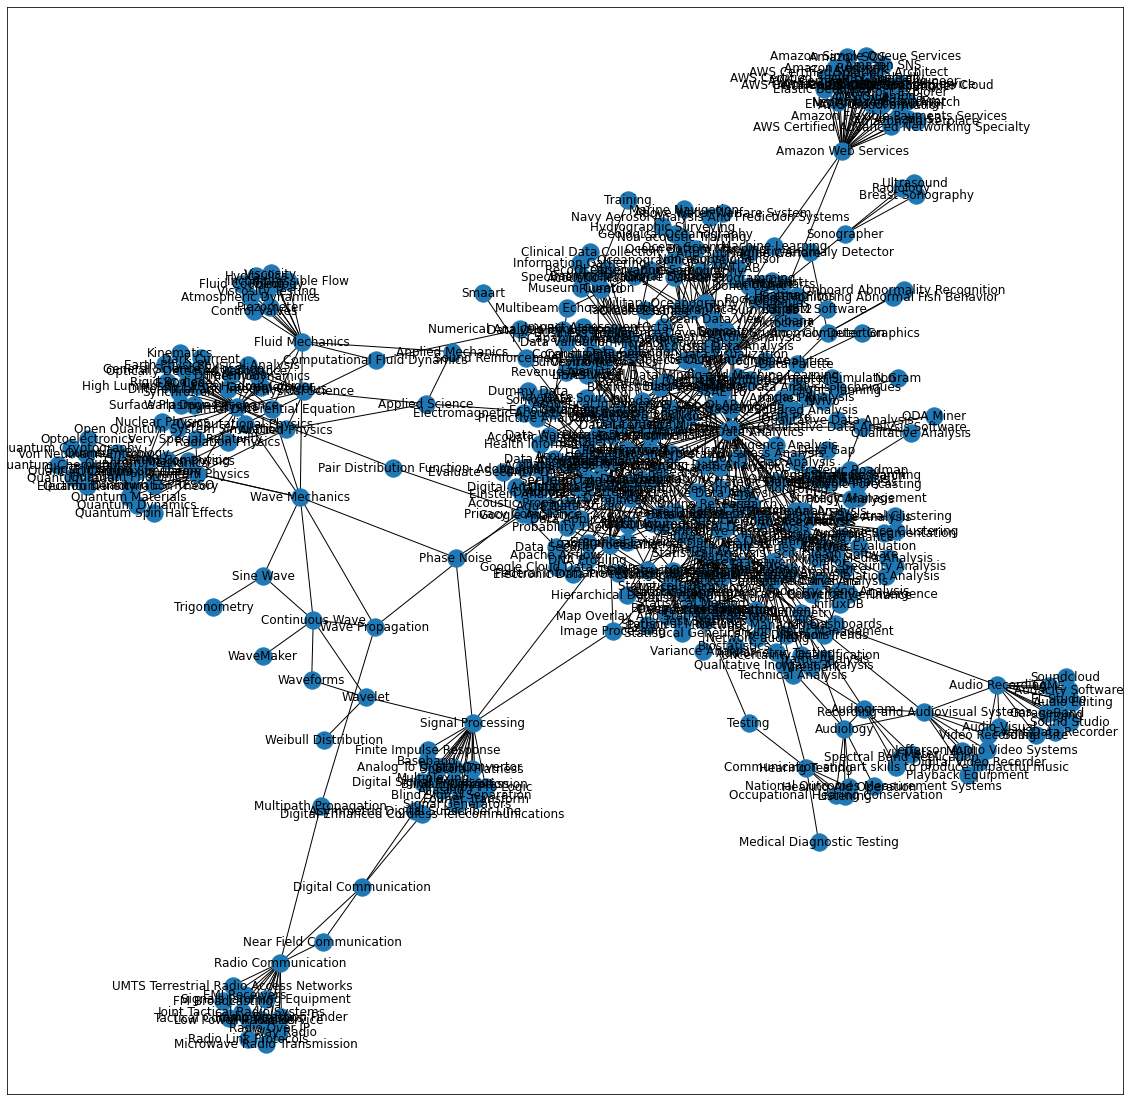

In [151]:
radius = 4
node_label = 'Acoustic Propagation'
subgraph = nx.ego_graph(UG, node_label, radius=radius)

nx.draw_networkx(subgraph)

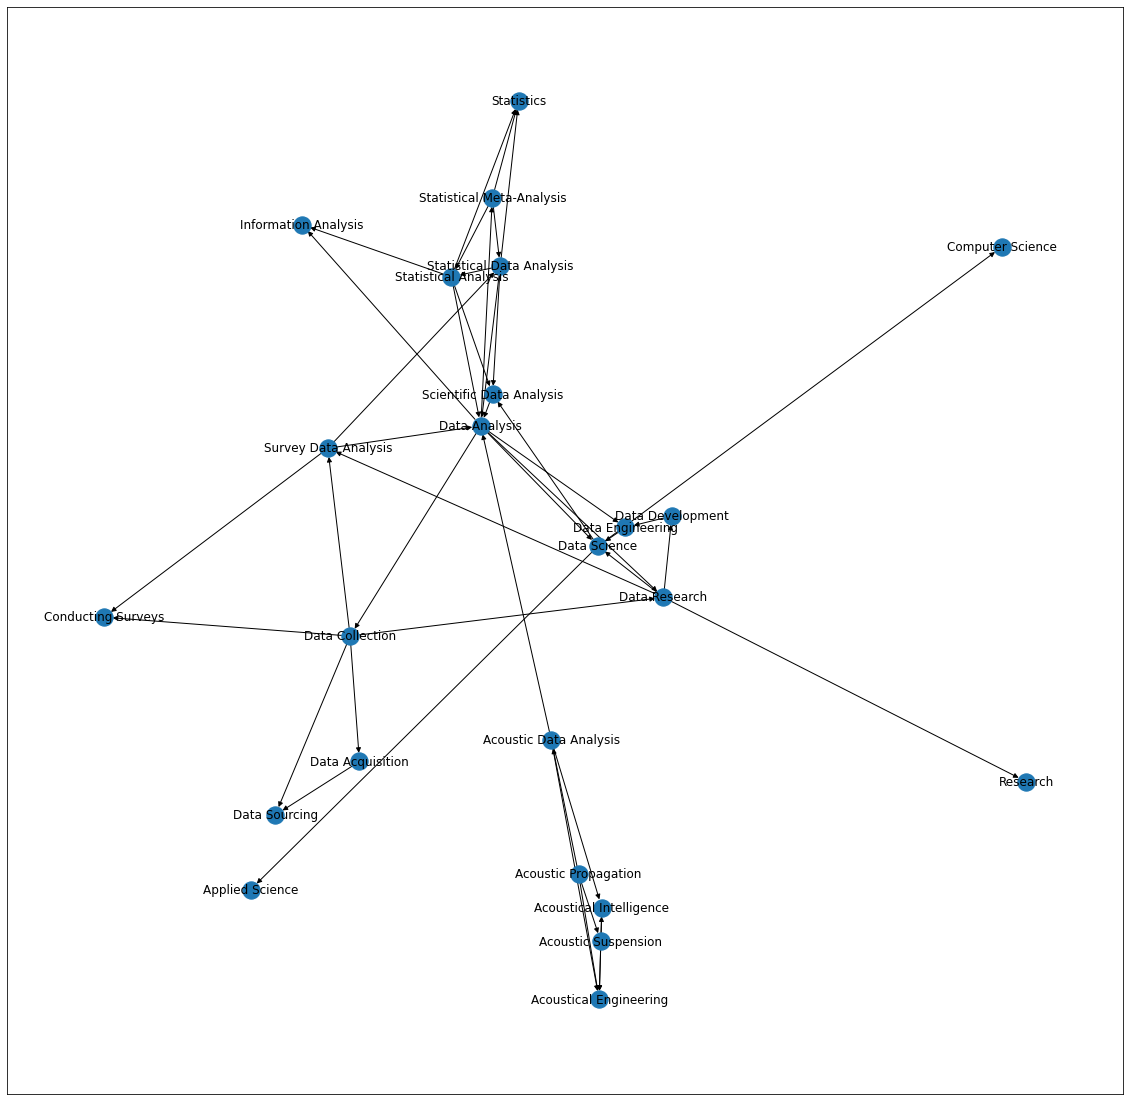

In [153]:
subgraph = nx.ego_graph(DG, node_label, radius=radius)

nx.draw_networkx(subgraph)

## Subgraph from a list of skills

- nodes need to be connected with edges
- finding shortest paths is one approach
- not all possible edges are captured by shortest paths

### Induced graph

- connects given nodes with all possible edges
- but if there's no direct edge, parts of subgraph may be left unconnected

In [176]:
skills = [
    'Python',
    'Computer Programming',
    'Cybersecurity',
    'Java Programming', 
 ]
DG.subgraph(skills).nodes

NodeView(('Python', 'Cybersecurity', 'Java Programming', 'Computer Programming'))

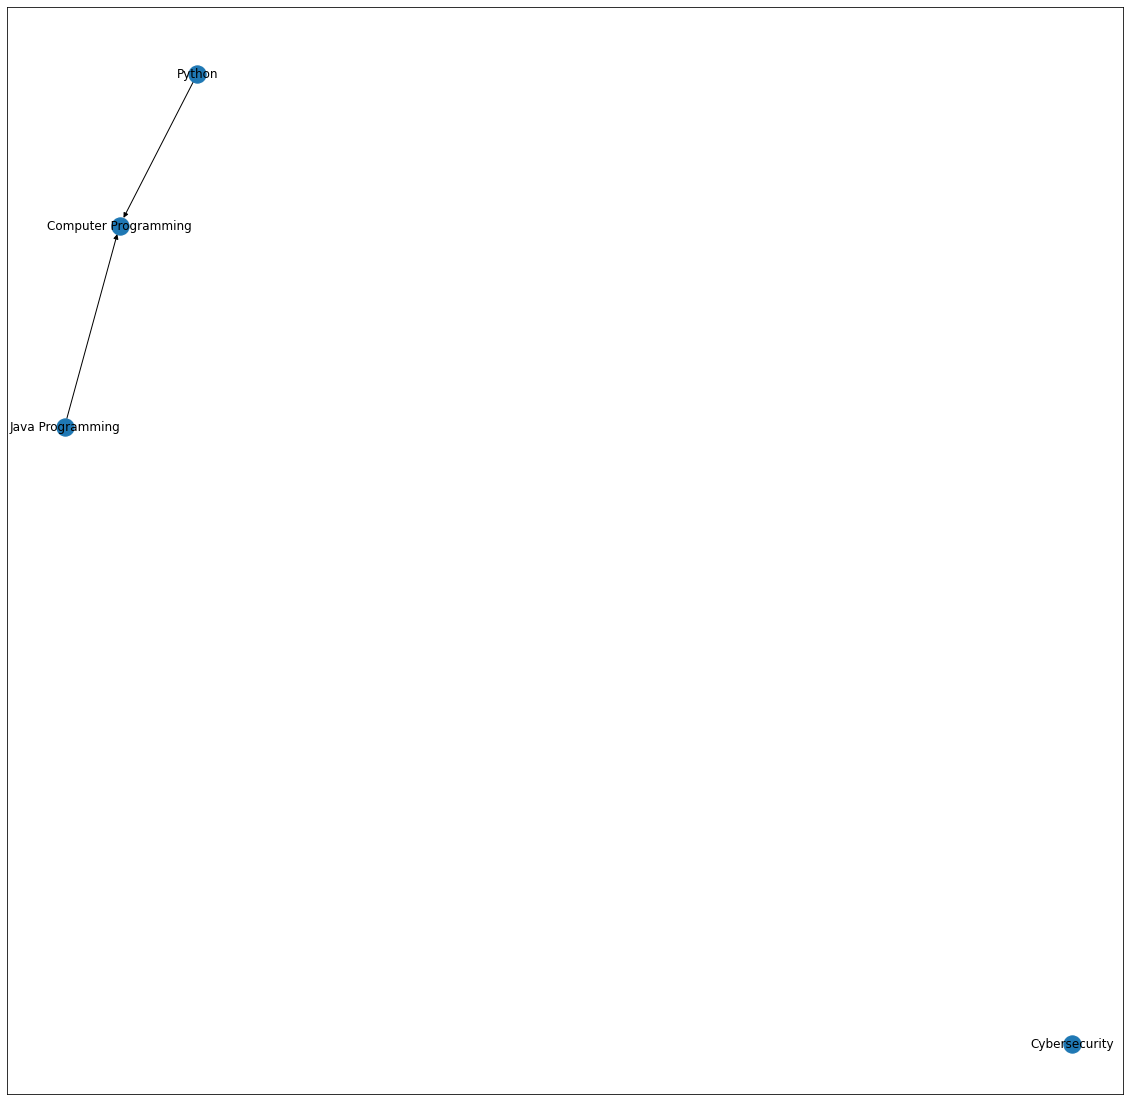

In [177]:
induced_subgraph = nx.induced_subgraph(DG, skills)
nx.draw_networkx(induced_subgraph)

### Shortest paths

- can be used to connect a list of skills
- looks for connections using intermediate nodes

In [139]:
nx.shortest_path(DG, "Python", "Java Programming")

['Python',
 'Computer Programming',
 'Writing Code',
 'Testing Code',
 'User Testing',
 'Test Scenario',
 'Scenario Analysis',
 'Evaluate Security Threat',
 'Threat Modeling',
 'Threat Detection',
 'Cyber Threat Intelligence',
 'Cybersecurity',
 'Classify Communication Systems',
 'Distributed Systems and Messaging',
 'Message Processing',
 'Transaction Processing',
 'Java Transaction API',
 'Java Programming']

In [155]:
def get_shortest_paths(nodes: List[str], UG: object, weight_attribute='weight'):
    """
    Get all shortest paths for a subgraph.

    Args:
        - nodes: selected skills strings
        - UG: undirected graph object
    """
    path_coll = set()
    for node_1 in test_nodes:
        for node_2 in test_nodes:
            if node_1 != node_2:
                paths = set(nx.shortest_path(UG, node_1, node_2, weight=weight_attribute))
                path_coll.update(paths)
    return path_coll

def draw_weighted_graph(nodes: List[str], parent_graph: object):
    paths = get_shortest_paths(nodes, UG)
    subgraph = parent_graph.subgraph(list(paths))
    return nx.draw_networkx(nx.subgraph(parent_graph, subgraph))


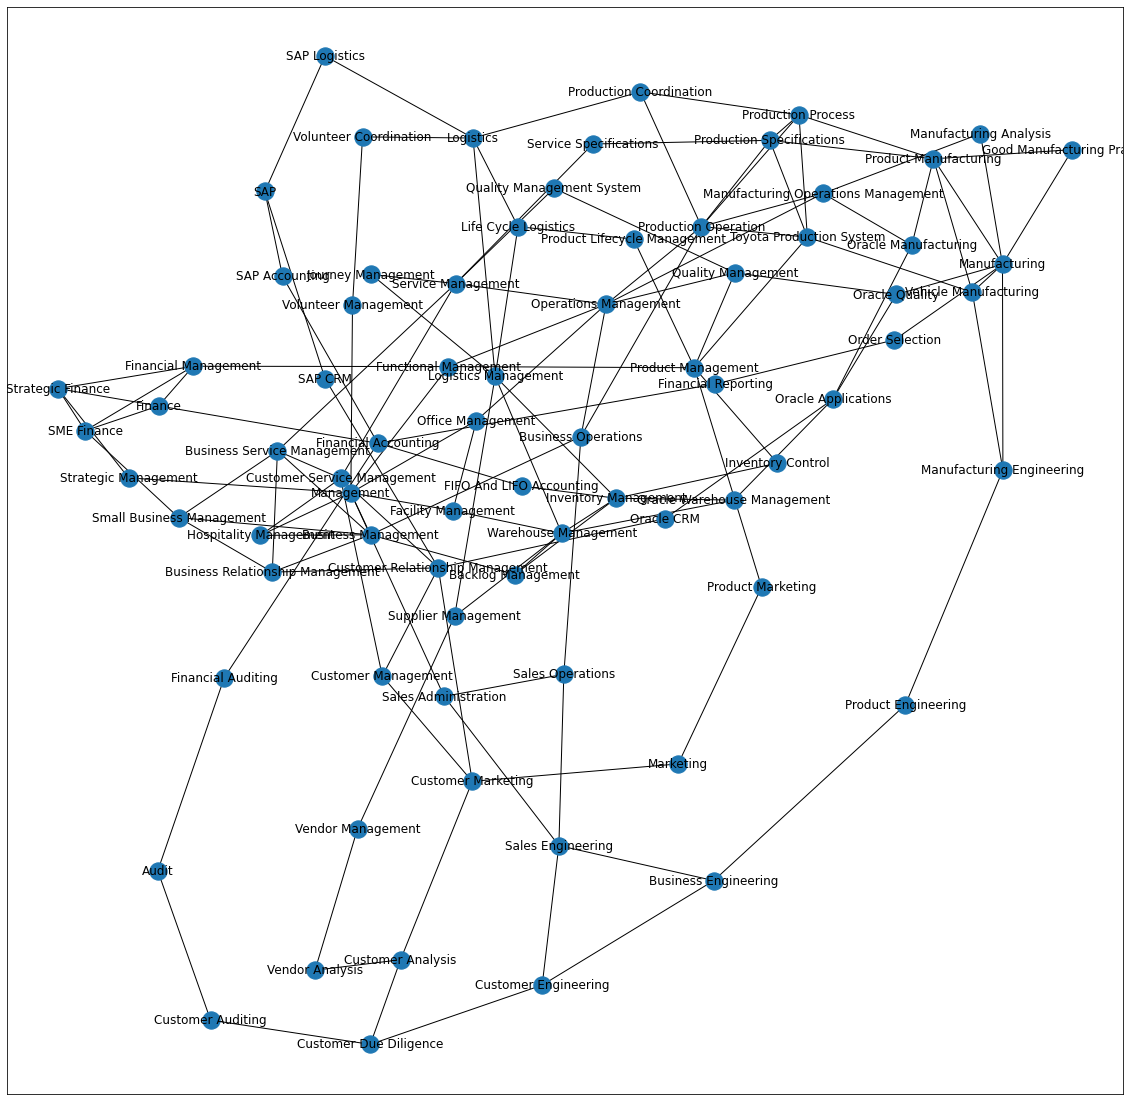

In [172]:
test_nodes = [
    'Manufacturing',
    'Production Operation',
    'Finance',
    'Customer Service Management',
    'Good Manufacturing Practices',
    'Customer Due Diligence',
    'Management',
    'Product Management',
    'Logistics',
    'Customer Relationship Management',
    'Warehouse Management'
]

draw_weighted_graph(test_nodes, UG)

# visual distance corresponds to semantic distance

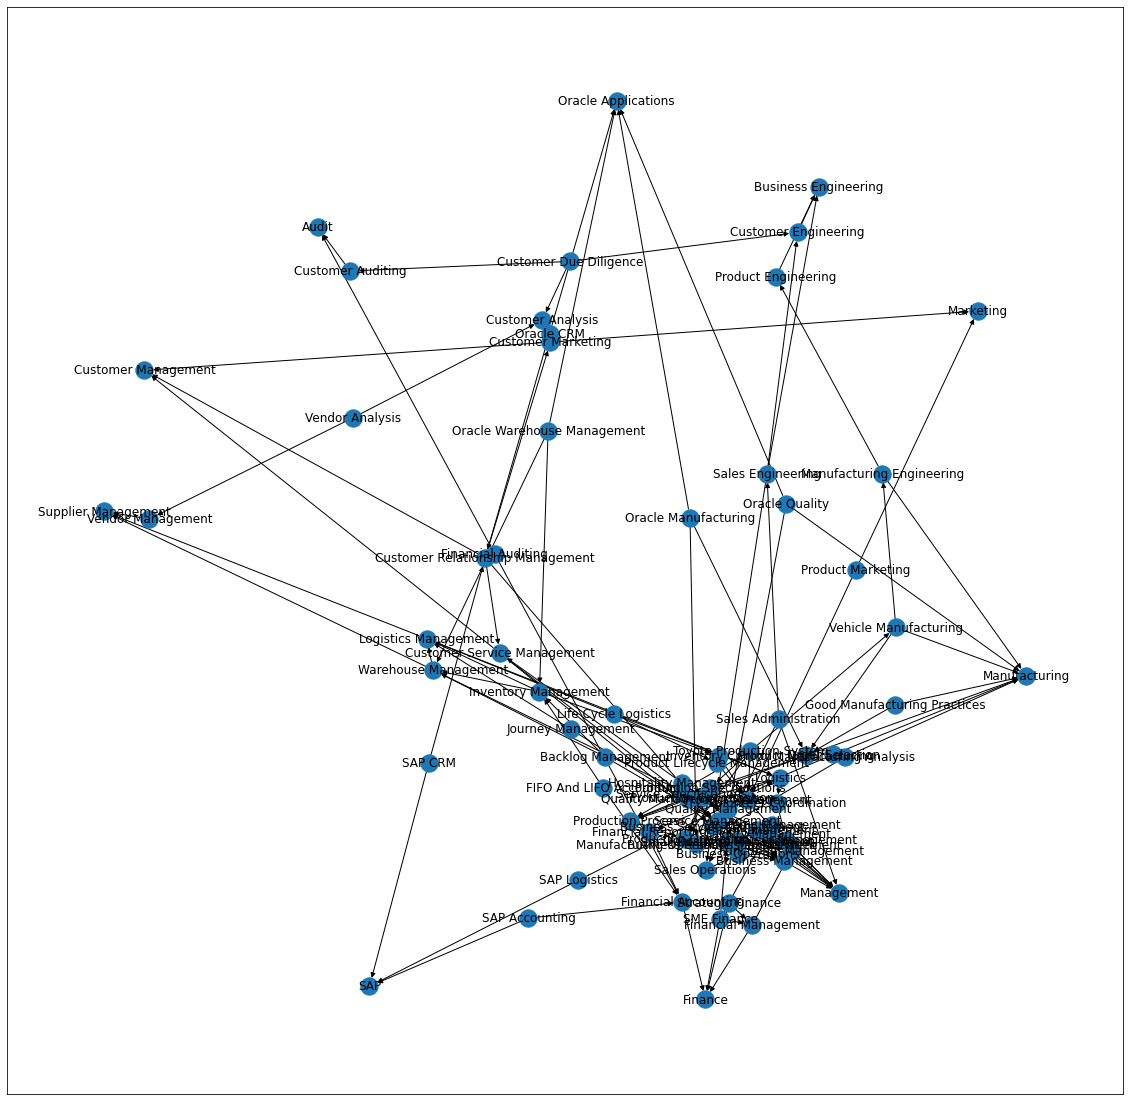

In [143]:
# if the graph is too cluttered, make it interactive -- see below
draw_weighted_graph(test_nodes, DG)

### Simple directed subgraph example
- using shortest paths to connect nodes

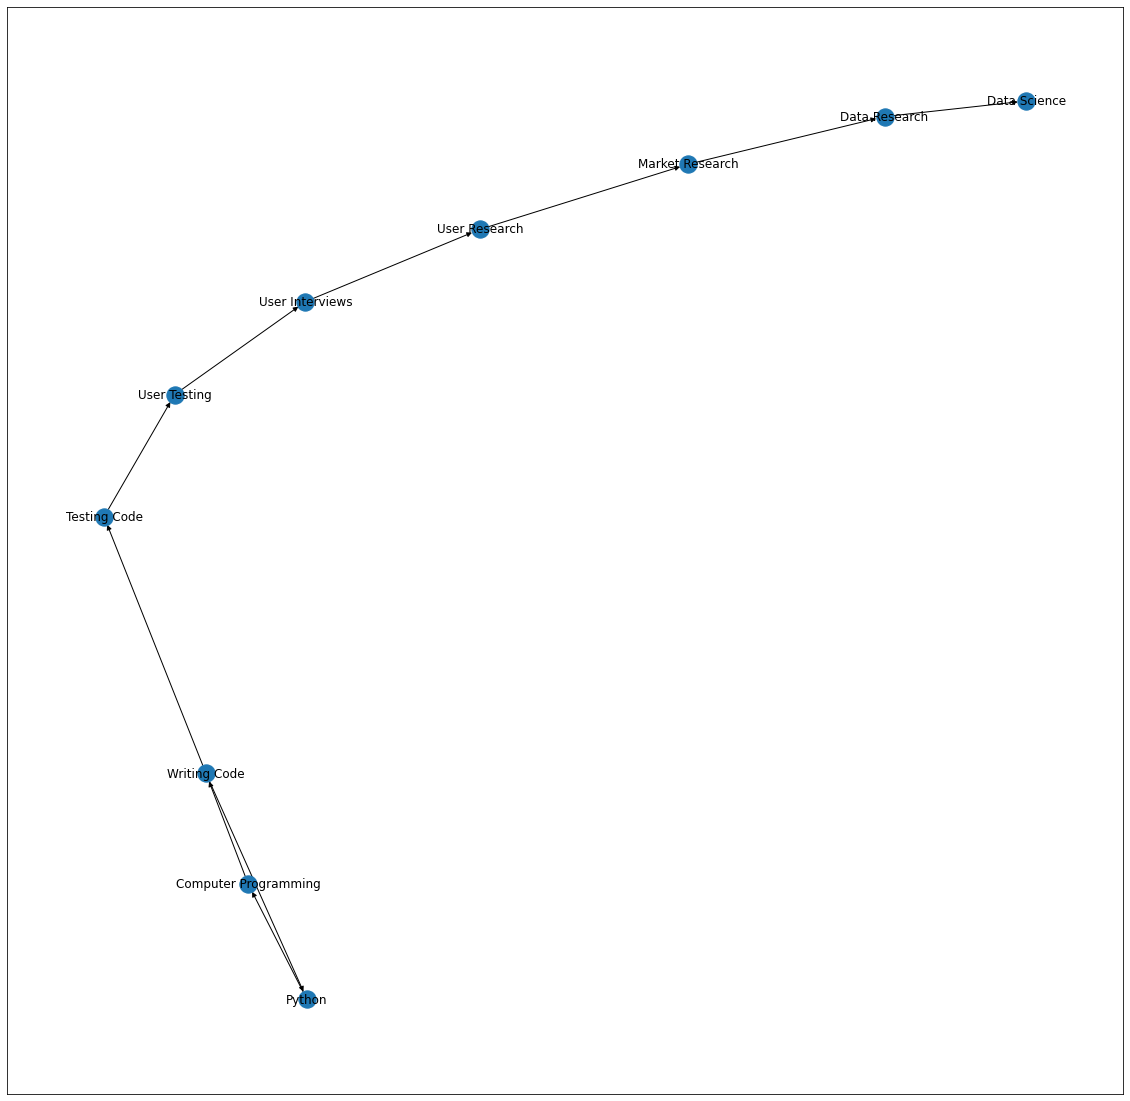

In [145]:
test_graph = nx.shortest_path(DG, "Python", "Data Science", "weight")
nx.draw_networkx(nx.subgraph(DG, test_graph))

### Simple undirected graph example
- using shortest paths to connect nodes

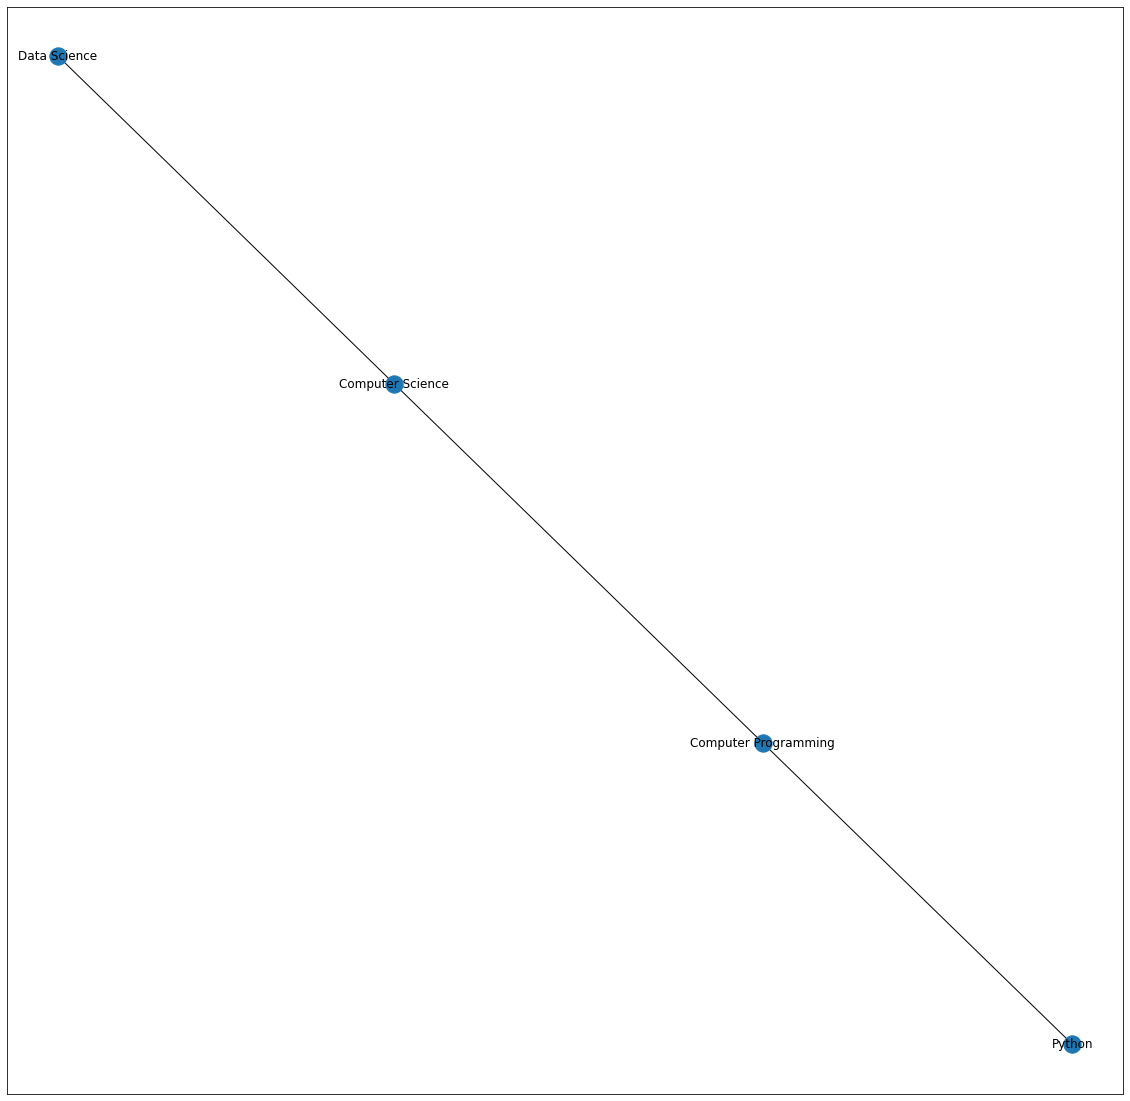

In [147]:
test_graph = nx.shortest_path(UG, "Python", "Data Science" )
nx.draw_networkx(nx.subgraph(UG, test_graph))

## Filter nodes

- Subgraphs can be created by filtering nodes

In [202]:
import re

target = 'Data Analysis'

def filter_node(node, target=target):
    if re.search(target, str(node), flags=re.I):
        return True
    else:
        return False

filtered_graph = nx.subgraph_view(DG, filter_node=filter_node)
filtered_graph.nodes

NodeView(('Acoustic Data Analysis', 'Data Analysis', 'Statistical Data Analysis', 'Strategic Data Analysis', 'Quantitative Data Analysis', 'Scientific Data Analysis', 'Non-acoustic Data Analysis', 'Survey Data Analysis', 'Guerrilla Data Analysis Techniques', 'Biostatistical Data Analysis', 'Qualitative Data Analysis', 'Qualitative Data Analysis Software'))

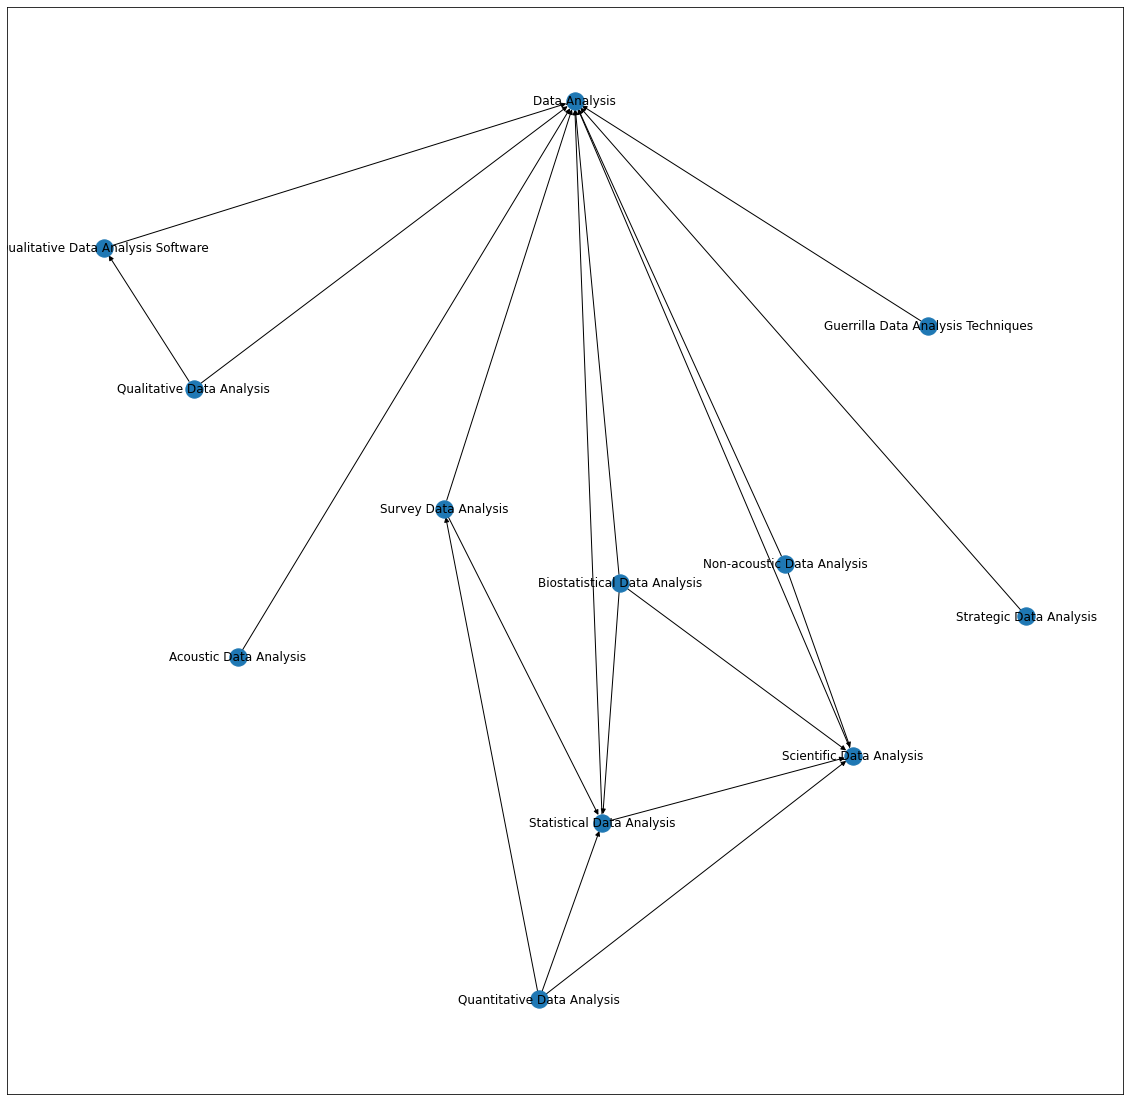

In [203]:
nx.draw_networkx(filtered_graph)

# Centrality

In [178]:
cent = nx.degree_centrality(DG)

In [179]:
cent_df = pd.DataFrame([(i, j) for i, j in cent.items()], columns=['skill', 'degree'])

In [180]:
cent_df.describe()

,degree
count,11161.000000
mean,0.000434
std,0.000439
min,0.000090
25%,0.000179
50%,0.000269
75%,0.000538
max,0.007796


# Clustering

## Clustering coeffecients

In [185]:
coeffs = [(skill, coeff) for skill, coeff in nx.clustering(DG).items()]
cluster_df = pd.DataFrame(coeffs, columns=["skill", "coeffecient"])
cluster_df = cluster_df.sort_values(by=['coeffecient'], ascending=False).copy()

In [186]:
cluster_df

,skill,coeffecient
7269,IBM Z,0.5
6912,Glass Flowing,0.5
630,Ambulatory Services,0.5
6954,Google Cloud Console,0.5
6952,Google Cloud CDN,0.5
...,...,...
6535,Multiplexers,0.0
6533,Multiple Inheritance,0.0
6532,Multiple Activation Key,0.0
6531,Multiplayer Online Battle Arena,0.0


In [187]:
cluster_df.describe()

,coeffecient
count,11161.000000
mean,0.113075
std,0.143468
min,0.000000
25%,0.000000
50%,0.066667
75%,0.166667
max,0.500000


In [188]:
# merge with centrality

cluster_df['cent_degree'] = cluster_df['skill'].map(cent_df.set_index('skill')['degree'])

In [189]:
cluster_df.sort_values(by=['cent_degree'], ascending=False)

,skill,coeffecient,cent_degree
345,Language and Linguistics,0.003208,0.007796
3926,SAP,0.029680,0.006541
81,Software Development,0.010656,0.006183
218,Data Analysis,0.017451,0.005556
1750,Java Programming,0.011689,0.005287
...,...,...,...
10491,IWork,0.000000,0.000090
4626,Spring Design,0.000000,0.000090
4826,Ticket operations,0.000000,0.000090
10484,MCU 8051 IDE,0.000000,0.000090


In [191]:
eigen_centrality = nx.eigenvector_centrality(DG, max_iter=1000)

In [200]:
eigen_centrality

{'.NET Assemblies': 0.00015719083574234754,
 '.NET Framework': 0.00014739098267886724,
 '.NET Core': 0.00014739098267886724,
 'ASP.NET MVC': 5.768885113611318e-05,
 '.NET Reflector': 7.886415230765509e-05,
 '.NET Remoting': 0.00010781337668111212,
 'IT Framework': 7.463861371540387e-05,
 'Web Framework': 5.591854245562718e-05,
 'Windows Remote Desktop': 3.957760599775512e-05,
 'Remote Desktop Software': 5.4127633797850816e-05,
 '12 Factor Authentication': 1.121569430891604e-150,
 'Identity Management': 9.338726831529482e-07,
 'Authentication Mechanism': 1.533372458567207e-55,
 'Perimeter Security': 5.066467645929429e-149,
 'Authentication and Authorization': 1.739075204161957e-55,
 'Access & Authentication': 1.2463478077754037e-55,
 'Digest Access Authentication': 8.932235099603496e-56,
 'Data Security': 4.871462428501389e-05,
 'Security': 0.0007516698079555381,
 '2 Way Radio': 6.807515976623667e-07,
 'Radio Direction': 5.148983392627073e-07,
 'Radio Communication': 1.998933636882984e-

In [217]:
cluster_df['eigen'] = cluster_df.skill.map(eigen_centrality)

In [223]:
cluster_df.describe()

,coeffecient,cent_degree,eigen
count,11161.000000,11161.000000,1.116100e+04
mean,0.113075,0.000434,5.379141e-04
std,0.143468,0.000439,9.450733e-03
min,0.000000,0.000090,8.712951e-161
25%,0.000000,0.000179,8.712951e-161
50%,0.066667,0.000269,2.404775e-158
75%,0.166667,0.000538,3.131391e-36
max,0.500000,0.007796,5.719630e-01


In [227]:
cluster_df.sort_values(by=['eigen'], ascending=False)[0:50]

,skill,coeffecient,cent_degree,eigen
1137,Artifact Research,0.287879,0.001075,0.571963
9051,Curatorial Assistance,0.450000,0.000448,0.403110
1240,Artifact Acquisition,0.388889,0.000896,0.344869
1271,Artifact Moving,0.452381,0.000627,0.282388
6540,Museum Curation,0.142857,0.000717,0.216404
1241,Artifact Conservation,0.310606,0.001075,0.209918
1270,Catalogue Artifacts,0.245455,0.000986,0.193341
1269,Artifact Storage,0.500000,0.000627,0.185897
1274,Artifact Preservation,0.344444,0.000896,0.138209
3181,Data Collection,0.036797,0.001971,0.136479


In [213]:
skill_to_eigen

{'Artifact Research': '0.57',
 'Curatorial Assistance': '0.40',
 'Artifact Acquisition': '0.34',
 'Artifact Moving': '0.28',
 'Museum Curation': '0.22',
 'Artifact Conservation': '0.21',
 'Artifact Storage': '0.19',
 'Catalogue Artifacts': '0.19',
 'Artifact Preservation': '0.14',
 'Data Collection': '0.14',
 'Artifact Maintenance': '0.10',
 'Conducting Surveys': '0.08',
 'Data Analysis': '0.08',
 'Data Research': '0.08',
 'Data Science': '0.08',
 'Specimen Collection': '0.08',
 'Survey Data Analysis': '0.08',
 'Artefact Analysis': '0.07',
 'Cataloguing': '0.07',
 'Data Sourcing': '0.07',
 'Metadata': '0.07',
 'Artifact Display': '0.06',
 'Scientific Data Analysis': '0.06',
 'Data Acquisition': '0.05',
 'Statistics': '0.05',
 'Taxonomy': '0.05',
 'Applied Science': '0.04',
 'Computer Science': '0.04',
 'Data Engineering': '0.04',
 'Engineering Surveying': '0.04',
 'Information Analysis': '0.04',
 'Research': '0.04',
 'Statistical Data Analysis': '0.04',
 'Biological Sample Collection':

In [211]:
cluster_df

,skill,coeffecient,cent_degree,eigen
7269,IBM Z,0.5,0.000179,0.00
6912,Glass Flowing,0.5,0.000179,0.00
630,Ambulatory Services,0.5,0.000179,0.00
6954,Google Cloud Console,0.5,0.000179,0.00
6952,Google Cloud CDN,0.5,0.000179,0.00
...,...,...,...,...
6535,Multiplexers,0.0,0.000090,0.00
6533,Multiple Inheritance,0.0,0.000090,0.00
6532,Multiple Activation Key,0.0,0.000179,0.00
6531,Multiplayer Online Battle Arena,0.0,0.000090,0.00


In [210]:
cluster_df.describe()

,coeffecient,cent_degree
count,11161.000000,11161.000000
mean,0.113075,0.000434
std,0.143468,0.000439
min,0.000000,0.000090
25%,0.000000,0.000179
50%,0.066667,0.000269
75%,0.166667,0.000538
max,0.500000,0.007796


## Cliques

In [69]:

maximal_cliques = list(nx.find_cliques(UG))

In [70]:
cliques = list(nx.enumerate_all_cliques(UG))

In [159]:
cliques[-1]

['Artifact Research',
 'Artifact Acquisition',
 'Artefact Analysis',
 'Artifact Conservation',
 'Artifact Storage',
 'Catalogue Artifacts',
 'Artifact Preservation',
 'Artifact Maintenance']

In [72]:
clique_df = pd.DataFrame({'clique': cliques})

In [73]:
clique_df

,clique
0,[.NET Assemblies]
1,[.NET Framework]
2,[.NET Core]
3,[ASP.NET MVC]
4,[.NET Reflector]
...,...
57656,"[Statistics, Statistical Analysis, Statistical..."
57657,"[Statistics, Statistical Analysis, Statistical..."
57658,"[Quality Improvement, Quality Management, Tota..."
57659,"[SAP, SAP Applications, SAP Implementation, SA..."


## Dominating set

In [75]:
dominating_df = pd.DataFrame({"item": list(nx.dominating_set(G)) })

In [76]:
dominating_df

,item
0,Oracle Essbase
1,Step Certification
2,Plastics Finishing
3,Object Query Language
4,Low Voltage Transistor Transistor Logic
...,...
7182,ExMark
7183,Quantum Spin Hall Effects
7184,Da Vinci Surgical Systems
7185,Splash Pages


# Filter nodes

In [83]:
import re

target = 'Data Analysis'

def filter_node(node, target=target):
    if re.search(target, str(node), flags=re.I):
        return True
    else:
        return False

nx.subgraph_view(DG, filter_node=filter_node).nodes

NodeView(('Acoustic Data Analysis', 'Data Analysis', 'Statistical Data Analysis', 'Strategic Data Analysis', 'Quantitative Data Analysis', 'Scientific Data Analysis', 'Non-acoustic Data Analysis', 'Survey Data Analysis', 'Guerrilla Data Analysis Techniques', 'Biostatistical Data Analysis', 'Qualitative Data Analysis', 'Qualitative Data Analysis Software'))

# Search for edges

In [145]:
sf.get_edges_for_skill(conn, skill_regex=".*Java.*")

,broad,narrow
0,Java Virtual Machine,Apache JMeter
1,Java Server Pages,Apache JMeter
2,Java Web Server,Apache JMeter
3,Java Servlet,Apache JMeter
4,Java EE,Apache JMeter
...,...,...
277,Java Web Server,Java Servlet
278,TypeScript Programming language,JavaScript Programming Language
279,Windows Image Acquisition,Java Advanced Imaging
280,XML Concepts,Java XML


# Create an interactive subgraph

- Any graph or subgraph can be made interactive as follows:


In [134]:
nt = Network(height=800, width=800, directed=True)
nt.toggle_hide_edges_on_drag(True)
nt.barnes_hut()
nt.from_nx(subgraph)
nt.show('subgraph.html')

# Get top nodes

In [ ]:
top_nodes = []
for node in DG:
    parents = DG.successors(node)
    if len(list(parents)) == 0:
        top_nodes.append(node)